In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import pandas as pd
import joblib
import time
import numpy as np
import gc
from tqdm import tqdm_notebook as tqdm
import warnings
import IPython.display as ipd
import librosa 
import librosa.display
import scipy.io.wavfile as wavfile
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

## Initial Exploration

In [132]:
DATA_FOLDERS = ['../Accent_classification_accentdb/accentdb_extended/data/' + x for x in ['british', 'indian']]

In [133]:
DATA_FOLDERS

['../Accent_classification_accentdb/accentdb_extended/data/british',
 '../Accent_classification_accentdb/accentdb_extended/data/indian']

In [58]:
filename = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\indian\speaker_01\indian_s01_011.wav'

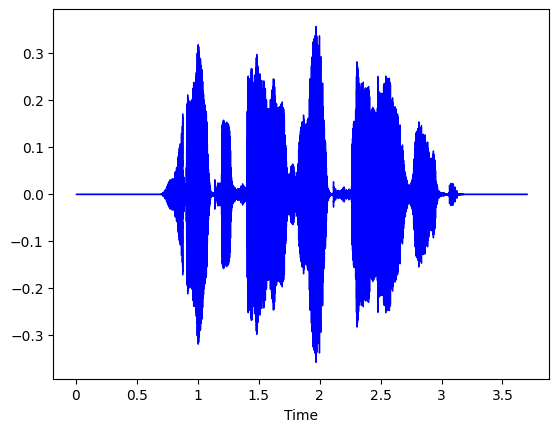

<Figure size 1400x500 with 0 Axes>

In [7]:
#Displaying the wavelenght of the filename american audio
Librosa_data, Librosa_sample_rate = librosa.load(filename)
librosa.display.waveshow(Librosa_data, sr=Librosa_sample_rate,color='blue')
plt.figure(figsize = (14,5))
ipd.Audio(filename)

In [201]:
def filename_extractor():
    speaker_files = []
    for dir in DATA_FOLDERS:
        lang = dir.split('/')[-1]
        speakers = os.listdir(dir)
        for speaker in speakers:
            audios = os.listdir(os.path.join(dir, speaker))
            for audio in audios:
                filename = os.path.join(dir,speaker,audio)
                speaker_files.append([lang, filename])
    return speaker_files

In [202]:
data = filename_extractor()

In [203]:
data[0]

['british',
 '../Accent_classification_accentdb/accentdb_extended/data/british\\speaker_01\\british_s01_001.wav']

In [219]:
audio_data = pd.DataFrame(data, columns = ['Speaker','audio_path'])
print(audio_data.head())
print(audio_data.shape)
print(audio_data['Speaker'].unique())

   Speaker                                         audio_path
0  british  ../Accent_classification_accentdb/accentdb_ext...
1  british  ../Accent_classification_accentdb/accentdb_ext...
2  british  ../Accent_classification_accentdb/accentdb_ext...
3  british  ../Accent_classification_accentdb/accentdb_ext...
4  british  ../Accent_classification_accentdb/accentdb_ext...
(2968, 2)
['british' 'indian']


In [220]:
audio_data.head()

,Speaker,audio_path
0,british,../Accent_classification_accentdb/accentdb_ext...
1,british,../Accent_classification_accentdb/accentdb_ext...
2,british,../Accent_classification_accentdb/accentdb_ext...
3,british,../Accent_classification_accentdb/accentdb_ext...
4,british,../Accent_classification_accentdb/accentdb_ext...


In [13]:
def mfcc_mean_extractor(file_name, n_mfcc=20):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_features

In [14]:
def mfcc_extractor(file_name, n_mfcc=20):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs_features

In [ ]:
def wav2spec(filename, hop_length=512, window_size=1024):
    y, sr = librosa.load(filename)
    window = np.hanning(window_size)
    out  = librosa.core.spectrum.stft(y, n_fft = window_size, hop_length = hop_length, 
        window=window)
    out = 2 * np.abs(out) / np.sum(window)
    amped = librosa.amplitude_to_db(out,ref=np.max)
    return amped

In [ ]:
# Filenames
filename1 = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\indian\speaker_01\indian_s01_001.wav'
filename2 = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\british\speaker_01\british_s01_001.wav'

In [ ]:
spec1 = wav2spec(filename1)
spec2 = wav2spec(filename2)

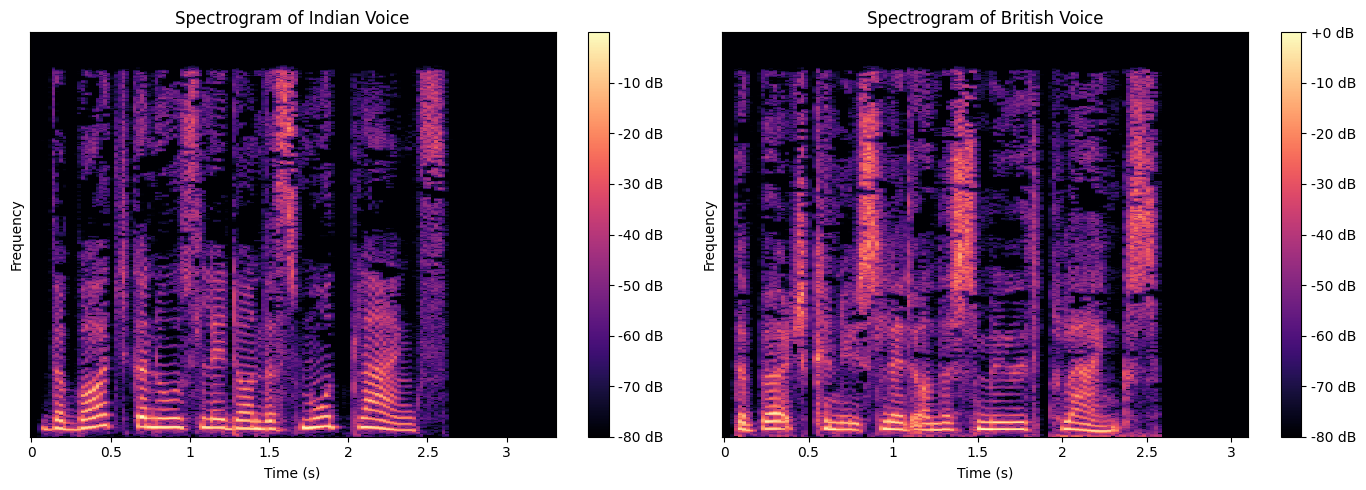

In [ ]:
# Plotting side by side
plt.figure(figsize=(14, 5))

# Plot 1
plt.subplot(1, 2, 1)
librosa.display.specshow(spec1, x_axis='time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Spectrogram of {}'.format('Indian Voice'))
plt.colorbar(format='%+2.0f dB')

# Plot 2
plt.subplot(1, 2, 2)
librosa.display.specshow(spec2, x_axis='time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Spectrogram of {}'.format('British Voice'))
plt.colorbar(format='%+2.0f dB')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [196]:
def run_in_batch(joblib_dir, batch_size, method):
    
    # Create the directory if it doesn't exist
    os.makedirs(joblib_dir, exist_ok=True)
    
    print(f'We need {audio_data.shape[0] // batch_size} number of iterations to write in batches')
    
    # Iterate over the DataFrame in batches
    for batch_start in tqdm(range(0, len(audio_data), batch_size)):
        batch_end = min(batch_start + batch_size, len(audio_data))
        batch = audio_data.iloc[batch_start:batch_end].copy()
        
        if method=='spectogram':
        # Apply wav_to_spec_inverted function to the batch and store the results in a new column
            batch['spectogram'] = batch.apply(lambda row: wav2spec(row['audio_path']), axis=1)
        elif method=='mfcc_all':
            batch['mfcc_all'] = batch.apply(lambda row: mfcc_extractor(row['audio_path']), axis=1)
        elif method=='mfcc_mean':
            batch['mfcc_mean'] = batch.apply(lambda row: mfcc_mean_extractor(row['audio_path']), axis=1)
            
        # Save the batch DataFrame as a joblib file
        joblib_filename = f'batch_{batch_start//batch_size}.joblib'
        joblib_filepath = os.path.join(joblib_dir, joblib_filename)
        joblib.dump(batch, joblib_filepath)
        
        del batch
        gc.collect()

In [221]:
def append_in_batch(joblib_dir, batch_size, method, save_path):
    global CURRENT_FILE
    joblib_files = sorted(os.listdir(joblib_dir))
    n_files = len(joblib_files)
    for i in tqdm(range(n_files)):
        file_path = os.path.join(joblib_dir, f"batch_{i}.joblib")
        batch_df = joblib.load(file_path)
        batch_df.reset_index(drop=True, inplace=True)
        audio_data = joblib.load(CURRENT_FILE)
        
        # Calculate the start and end indices for assigning values
        start_index = i * batch_size
        end_index = min((i+1)*batch_size, len(audio_data))
        
        #Adjust index of batch_df to match the desired range
        batch_df.index = batch_df.index + start_index
        # Assign values from the batch DataFrame to the corresponding rows in audio_data
        audio_data.loc[start_index:end_index-1, method] = batch_df[method]
        # Save the batch DataFrame as a joblib file
        joblib.dump(audio_data, save_path)
        CURRENT_FILE = save_path
        del batch_df, audio_data
        gc.collect()
        

In [102]:
def pad_array(array, max_len, pad_value=0):
    current_len = array.shape[1]  # Assuming mfcc_all contains 2D arrays
    if current_len < max_len:
        pad_width = ((0, 0), (0, max_len - current_len))
        padded_array = np.pad(array, pad_width, mode='constant', constant_values=pad_value)
        return padded_array
    else:
        return array

In [103]:
def pad_array_and_retain_speaker(row, max_len, method, pad_value=0):
    mfcc_padded = pad_array(row[method], max_len, pad_value)
    return pd.Series({'Speaker': row['Speaker'], method: mfcc_padded})

In [107]:
def make_dataset(method, langs_df=None):
    if langs_df is None:
        langs_df = joblib.load(method+'_data.pkl')
    langs = ['indian', 'british']
    os.makedirs(method, exist_ok=True)
    for lang in langs:
        data = np.array(langs_df.loc[langs_df['Speaker'] == lang, method].tolist())
        joblib.dump(data, os.path.join(method, lang+'_'+method+'_data.pkl'))

## Using MFCC Vectors

In [ ]:
mfccs = librosa.feature.mfcc(y=Librosa_data, sr=Librosa_sample_rate, n_mfcc=20)
print(mfccs.shape)

(20, 143)


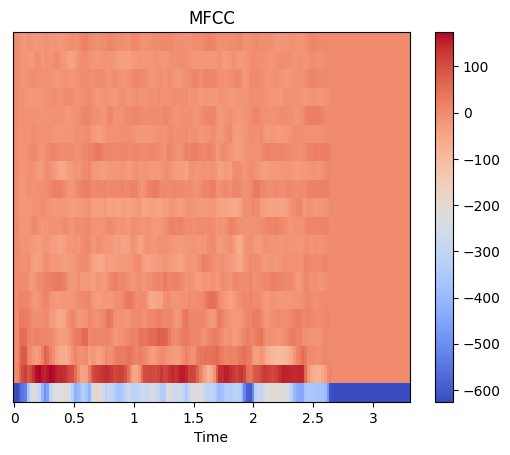

In [ ]:
# Display MFCCs
librosa.display.specshow(mfccs,sr=Librosa_sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

### Padding for MFCC

In [2]:
df = joblib.load('/mnt/e/VSCode/Applied-ML/Project/Accent_Conversion/mfcc_all_data.pkl')

In [3]:
langs=['indian', 'british']
method='mfcc_all'

In [4]:
shapes = df.loc[df['Speaker'].isin(langs), [method]].apply(lambda x:x.item().shape[-1], axis=1)

(array([2.700e+01, 4.700e+01, 5.000e+01, 3.680e+02, 9.500e+02, 1.221e+03,
        2.660e+02, 3.300e+01, 5.000e+00, 1.000e+00]),
 array([ 78. ,  93.1, 108.2, 123.3, 138.4, 153.5, 168.6, 183.7, 198.8,
        213.9, 229. ]),
 <BarContainer object of 10 artists>)

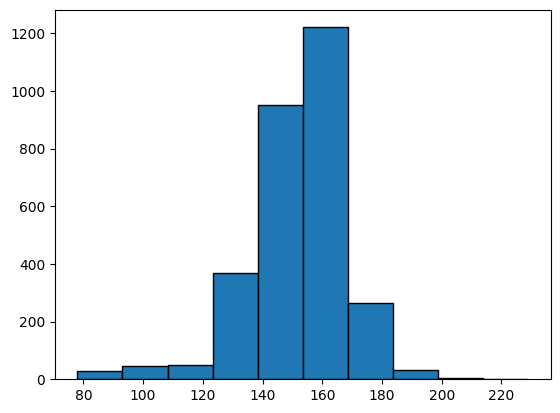

In [5]:
plt.hist(shapes, edgecolor='black')

In [6]:
max_len = shapes.max()

In [7]:
max_len

229

In [21]:
langs_df_padded = df.apply(lambda row:pad_array_and_retain_speaker(row, max_len, method), axis=1)

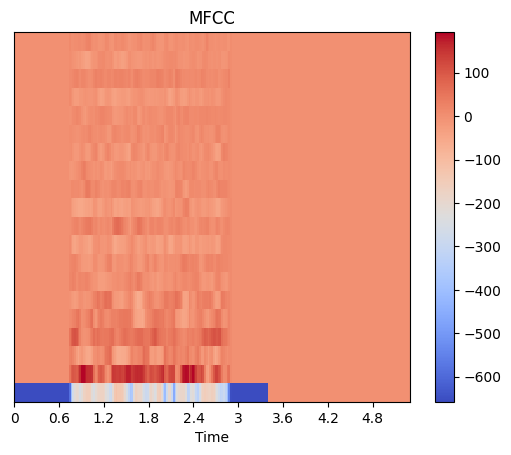

In [29]:
mfccs = langs_df_padded[['mfcc_all']].iloc[18].item()
librosa.display.specshow(mfccs,sr=22050, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

In [24]:
padded_shapes = langs_df_padded.loc[langs_df_padded['Speaker'].isin(langs), [method]].apply(lambda x:x.item().shape[-1], axis=1)

(array([   0.,    0.,    0.,    0.,    0., 2968.,    0.,    0.,    0.,
           0.]),
 array([228.5, 228.6, 228.7, 228.8, 228.9, 229. , 229.1, 229.2, 229.3,
        229.4, 229.5]),
 <BarContainer object of 10 artists>)

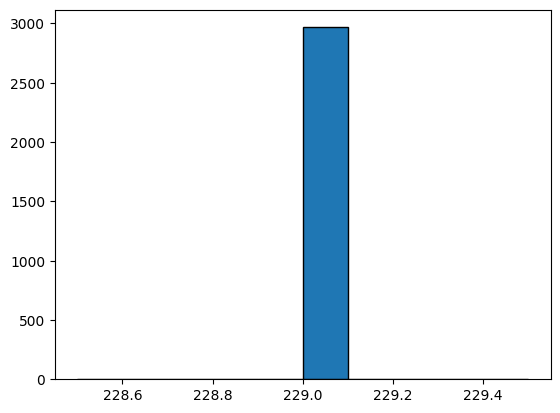

In [25]:
plt.hist(padded_shapes, edgecolor='black')

In [174]:
make_dataset('mfcc_mean')

In [46]:
make_dataset('mfcc_all', langs_df_padded)

## Using Spectograms

### The mfcc worked since they were storage-wise less intensive. For spectogram we will predecide the languages to be indian to british, and also code them as 0 and 1 to reduce space

In [215]:
methods = ['spectogram']
joblib_dirs = ['batch_data/'+method for method in methods]
batch_size = 100

In [197]:
for joblib_dir, method in zip(joblib_dirs, methods):
    run_in_batch(joblib_dir, batch_size, method)

We need 29 number of iterations to write in batches


  0%|          | 0/30 [00:00<?, ?it/s]

In [222]:
audio_data.drop(columns=['audio_path'], inplace=True)

In [223]:
def write_file():
    for joblib_dir, method in zip(joblib_dirs, methods):
        global CURRENT_FILE
        CURRENT_FILE = str(method) + '_data.pkl'
        current_df = audio_data.copy()
        current_df[method] = pd.NA
        joblib.dump(current_df, CURRENT_FILE)
        append_in_batch(joblib_dir, batch_size, method, CURRENT_FILE)
        del current_df
        gc.collect()

In [224]:
write_file()

  0%|          | 0/30 [00:00<?, ?it/s]

In [87]:
df = joblib.load('spectogram_data.pkl')

In [88]:
df.head()

,Speaker,spectogram
0,british,"[[-80.0, -80.0, -73.22522, -80.0, -28.05658, -..."
1,british,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,british,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,british,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,british,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [89]:
langs=['indian', 'british']
method='spectogram'

In [90]:
df[df[method].isnull()]

,Speaker,spectogram


In [91]:
shapes = df[[method]].apply(lambda x:x.item().shape[1], axis=1)

(array([2.600e+01, 4.600e+01, 5.400e+01, 2.690e+02, 8.940e+02, 1.335e+03,
        2.970e+02, 4.000e+01, 6.000e+00, 1.000e+00]),
 array([ 78. ,  93.1, 108.2, 123.3, 138.4, 153.5, 168.6, 183.7, 198.8,
        213.9, 229. ]),
 <BarContainer object of 10 artists>)

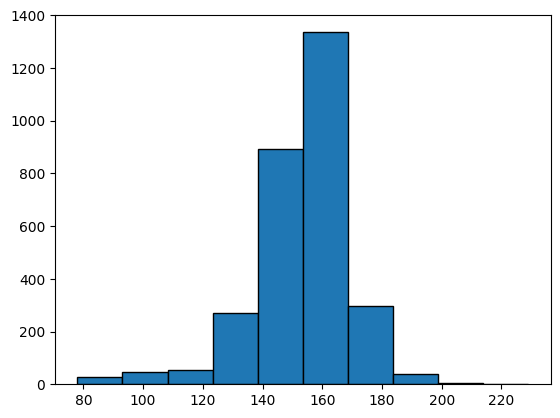

In [92]:
plt.hist(shapes, edgecolor='black')

In [93]:
max_len = shapes.max()

In [4]:
max_len

229

In [5]:
joblib.dump(max_len, 'pad_length.pkl')

['pad_length.pkl']

In [95]:
min_spec_value = np.min(df[[method]].iloc[0].item())

In [96]:
min_spec_value

-80.0

In [97]:
most_len = 183

In [104]:
langs_df_padded = df.apply(lambda row:pad_array_and_retain_speaker(row, max_len, method, pad_value=min_spec_value), axis=1)

In [105]:
padded_spec = langs_df_padded[[method]].iloc[2000].item()

In [106]:
padded_spec.shape

(513, 229)

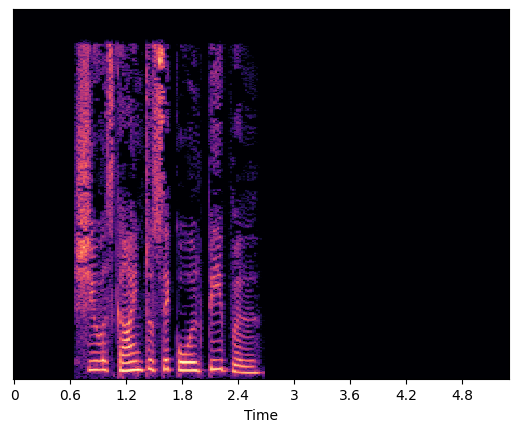

In [107]:
librosa.display.specshow(padded_spec, x_axis='time')

In [ ]:
make_dataset('spectogram', langs_df_padded)

In [2]:
X = joblib.load('spectogram/indian_spectogram_data.pkl')
y = joblib.load('spectogram/british_spectogram_data.pkl')

In [3]:
pca = PCA()

In [4]:
# Assuming X is your input data with shape (n_samples, n_freq, timesteps)
n_samples, n_freq, timesteps = X.shape

In [50]:
n_samples, n_freq, timesteps

(1484, 513, 229)

In [40]:
# Reshape the input data into a 2D matrix
X_2d = np.reshape(X, (n_samples, n_freq * timesteps))
y_2d = np.reshape(y, (n_samples, n_freq * timesteps))

In [14]:
n_freq * timesteps

117477

In [75]:
n_components = 1444
n_dim = int(np.sqrt(n_components))

In [76]:
# Apply PCA to the 2D matrix
pca_x = PCA(n_components = n_components)
pca_y = PCA(n_components = n_components)

In [77]:
X_pca_2d = pca_x.fit_transform(X_2d)
y_pca_2d = pca_y.fit_transform(y_2d)

In [78]:
# Reshape the PCA-transformed data back into a 3D tensor
X_pca = X_pca_2d.reshape(n_samples, n_dim, n_dim)
y_pca = y_pca_2d.reshape(n_samples, n_dim, n_dim)

In [79]:
padded_spec_pca = X_pca[0]

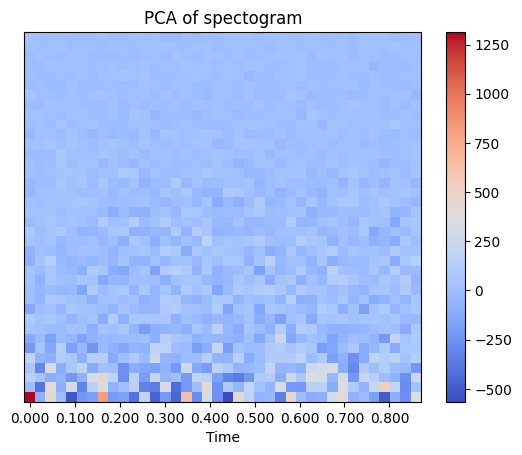

In [113]:
plt.title('PCA of spectogram')
librosa.display.specshow(padded_spec_pca, x_axis='time')
plt.colorbar()

In [80]:
padded_spec_pca.shape

(38, 38)

In [84]:
reconstructed_padded_spec = pca_x.inverse_transform(padded_spec_pca.reshape(n_components)).ravel().reshape(n_freq, timesteps)

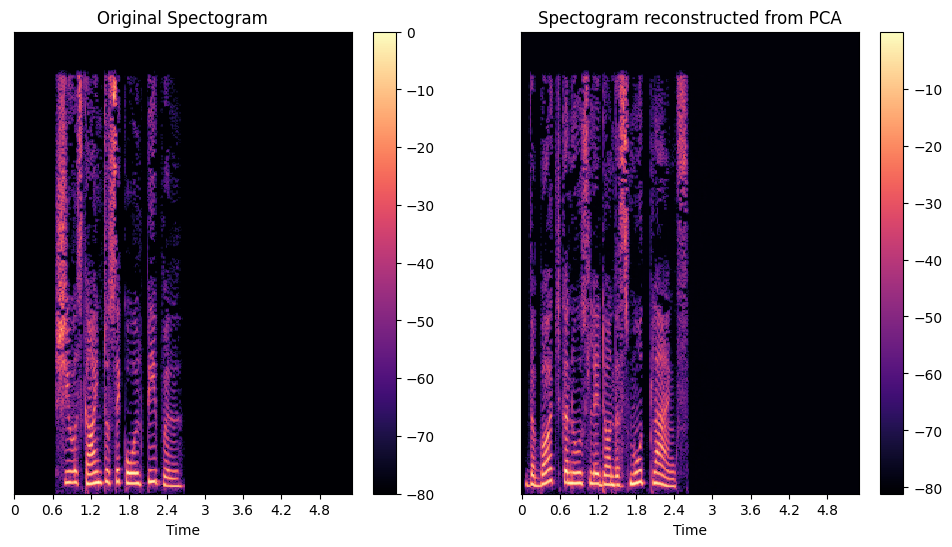

In [109]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(padded_spec, x_axis='time')
plt.title('Original Spectogram')
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(reconstructed_padded_spec, x_axis='time')
plt.title('Spectogram reconstructed from PCA')
plt.colorbar()

In [110]:
joblib.dump(X_pca,'spectogram/indian_spectogram_pca_data.pkl')
joblib.dump(y_pca,'spectogram/british_spectogram_pca_data.pkl')

['spectogram/british_spectogram_pca_data.pkl']

In [111]:
joblib.dump(pca_x, 'spectogram/pca_x.joblib')
joblib.dump(pca_y, 'spectogram/pca_y.joblib')

['spectogram/pca_y.joblib']

In [7]:
joblib.dump(n_components, 'spectogram/n_components.pkl')
joblib.dump(n_freq, 'spectogram/n_freq.pkl')
joblib.dump(timesteps, 'spectogram/timesteps.pkl')
joblib.dump(n_dim, 'spectogram/n_dim.pkl')

['spectogram/n_dim.pkl']